- Emma Rey Sánchez - 202110801
- Catalina Royo-Villanova Seguí - 202104665
# Proyecto Final

In [5]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

## Calibración de la cámara

In [6]:
def calibracion():
    circle_board_size = (5, 4) # Tamaño del tablero circular
    circle_size_mm = 50
   
    # Crear objeto para almacenar las coordenadas 3D del tablero circular
    objp = np.zeros((circle_board_size[0] * circle_board_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:circle_board_size[0], 0:circle_board_size[1]].T.reshape(-1, 2) * circle_size_mm

    # Listas para almacenar coordenadas 3D e 2D del tablero
    obj_points = []  # Coordenadas 3D del mundo real
    img_points = []  # Coordenadas 2D en la imagen

    # Obtener la lista de nombres de archivos de imágenes en la carpeta
    image_folder = 'ImagenesCirculos/'  # Reemplaza con la ruta de tu carpeta
    # image_folder = 'ImagenesCalibracion/'  # Reemplaza con la ruta de tu carpeta
    image_files = glob.glob(f'{image_folder}*.jpg')  # Puedes ajustar la extensión de archivo según tus imágenes
    for image in image_files:
        # Leer la imagen
        img = cv2.imread(image)
        imagen_circulos = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Intentar encontrar el patrón de círculos en la imagen
        ret, corners = cv2.findCirclesGrid(gray, circle_board_size, flags=cv2.CALIB_CB_SYMMETRIC_GRID)
        print(image, ret)
        for i in corners:
            cv2.circle(imagen_circulos, tuple(map(int, i[0])), 2, (0, 255, 0), -1)
        plt.imshow(imagen_circulos)
        plt.show()

        if ret:
            obj_points.append(objp)
            img_points.append(corners)

    # Calibrar la cámara
    ret, mtx, dist, _, _ = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

    # Guardar los parámetros de calibración en un archivo
    np.savez('parametros_calibracion.npz', mtx=mtx, dist=dist)

    print('Calibración completada. Parámetros guardados en parametros_calibracion.npz')



ImagenesCirculos/Imagen_circulos35.jpg True


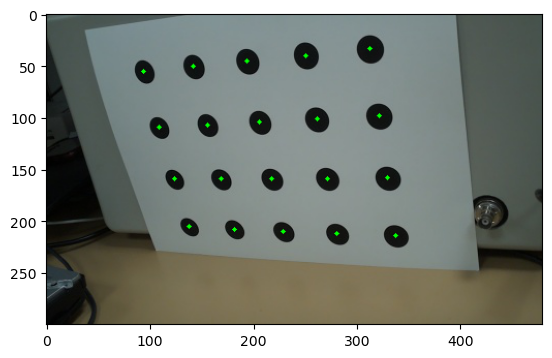

ImagenesCirculos/Imagen_circulos21.jpg True


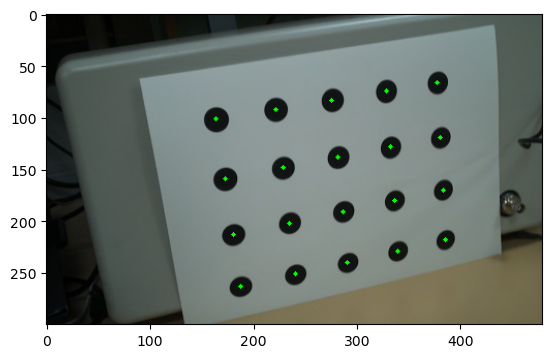

ImagenesCirculos/Imagen_circulos20.jpg True


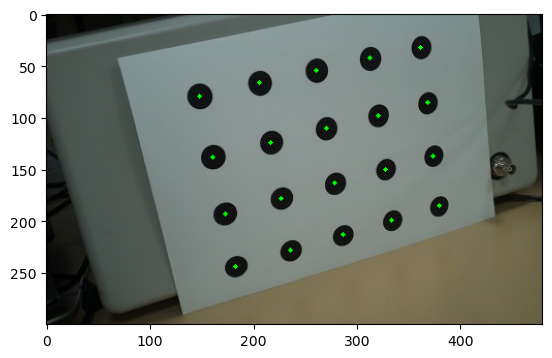

ImagenesCirculos/Imagen_circulos34.jpg True


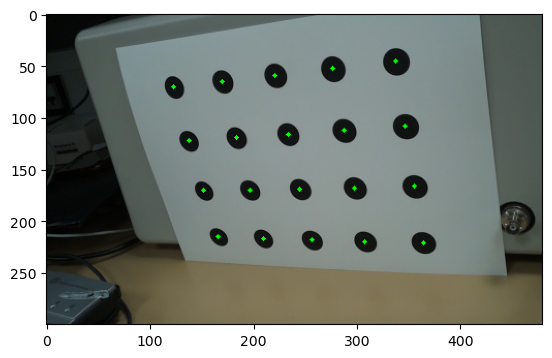

ImagenesCirculos/Imagen_circulos22.jpg True


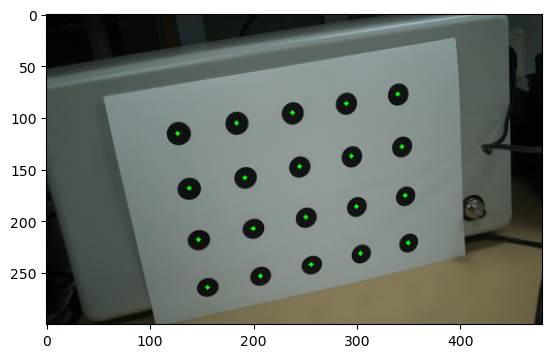

ImagenesCirculos/Imagen_circulos36.jpg True


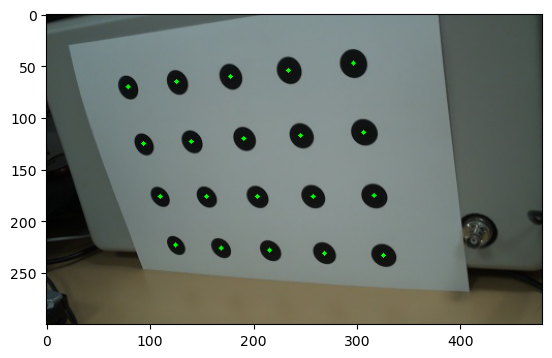

ImagenesCirculos/Imagen_circulos37.jpg True


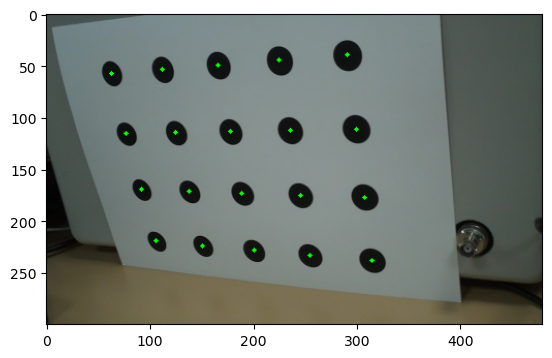

ImagenesCirculos/Imagen_circulos23.jpg True


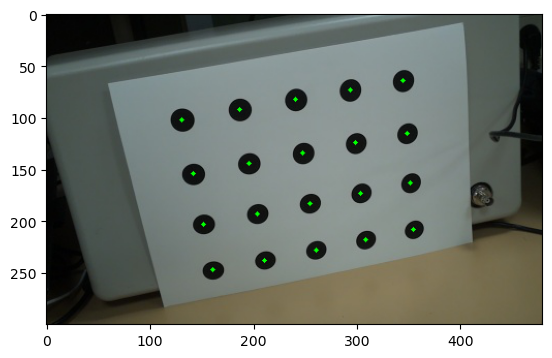

ImagenesCirculos/Imagen_circulos9.jpg True


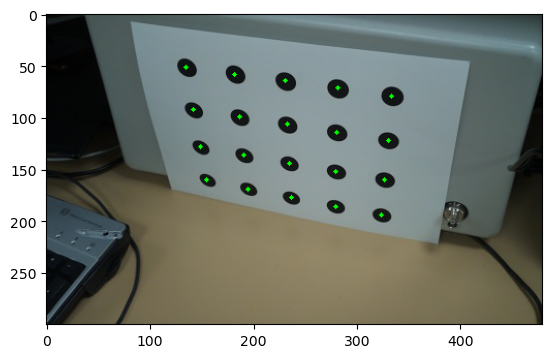

ImagenesCirculos/Imagen_circulos27.jpg True


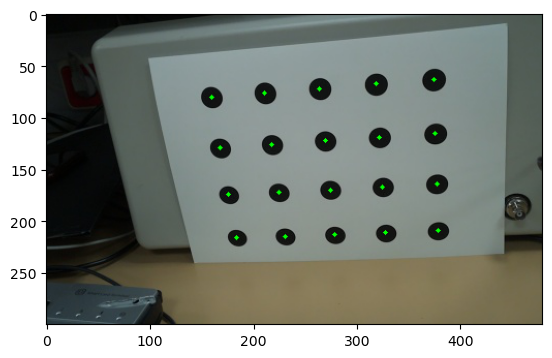

ImagenesCirculos/Imagen_circulos33.jpg True


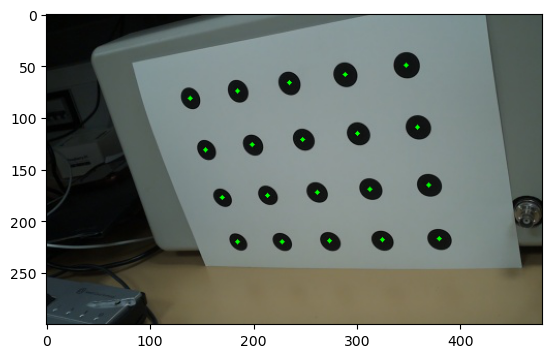

ImagenesCirculos/Imagen_circulos32.jpg True


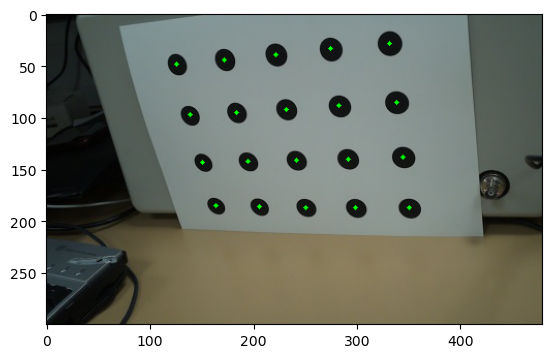

ImagenesCirculos/Imagen_circulos26.jpg True


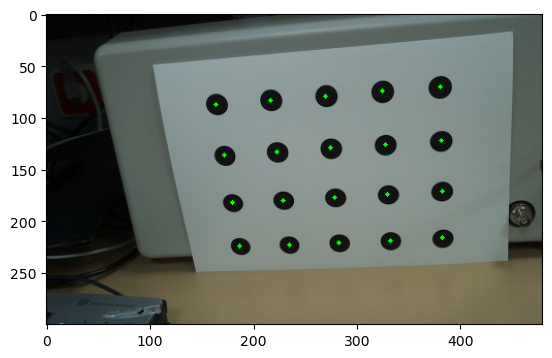

ImagenesCirculos/Imagen_circulos8.jpg True


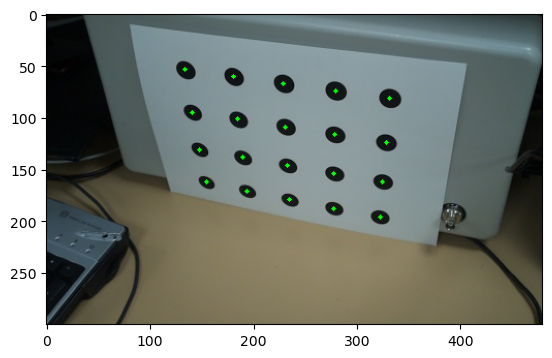

ImagenesCirculos/Imagen_circulos30.jpg True


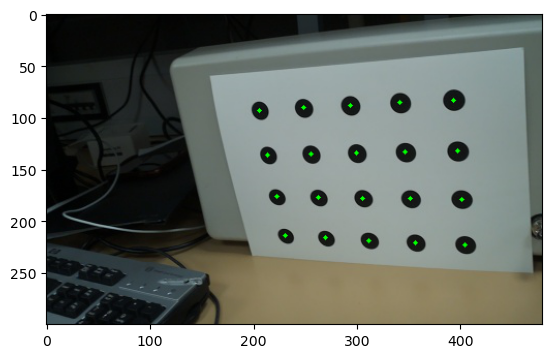

ImagenesCirculos/Imagen_circulos24.jpg True


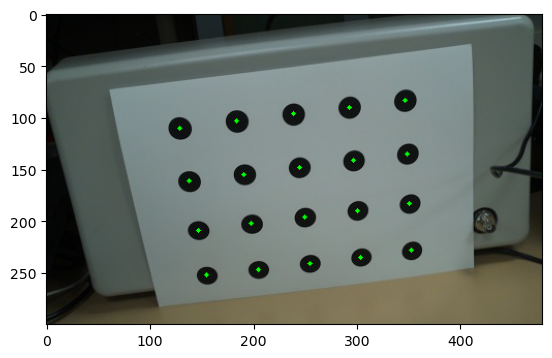

ImagenesCirculos/Imagen_circulos18.jpg True


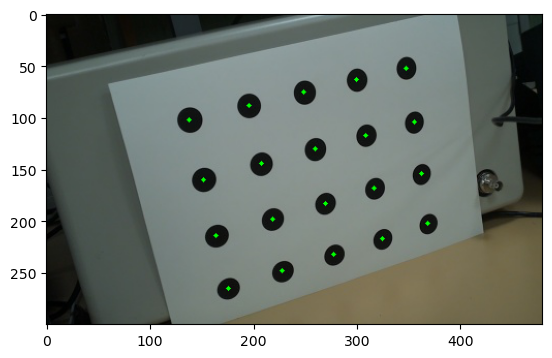

ImagenesCirculos/Imagen_circulos19.jpg True


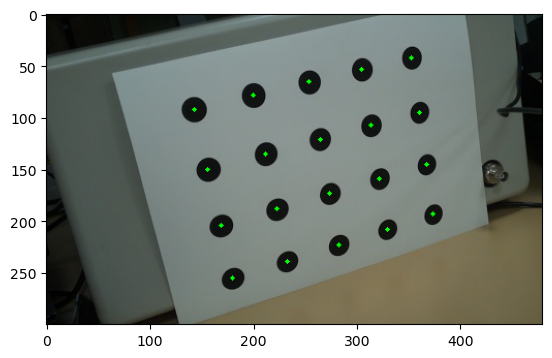

ImagenesCirculos/Imagen_circulos25.jpg True


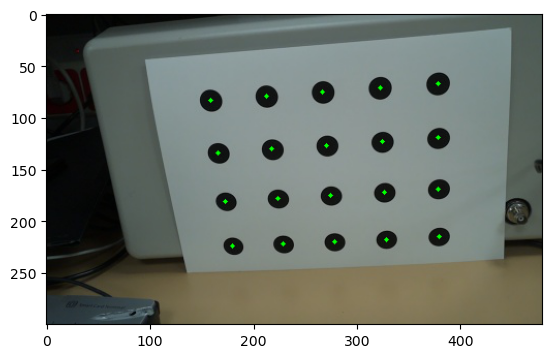

ImagenesCirculos/Imagen_circulos31.jpg True


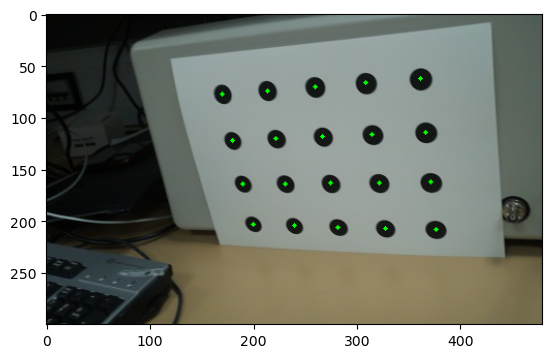

ImagenesCirculos/Imagen_circulos42.jpg True


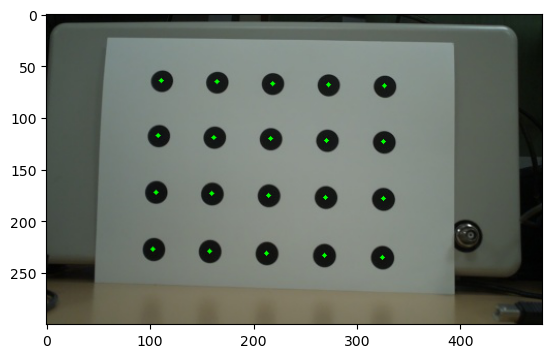

ImagenesCirculos/Imagen_circulos41.jpg True


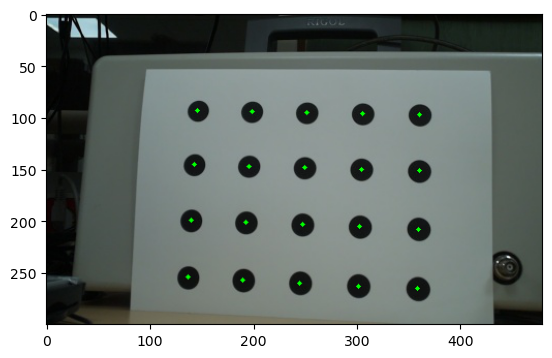

ImagenesCirculos/Imagen_circulos40.jpg True


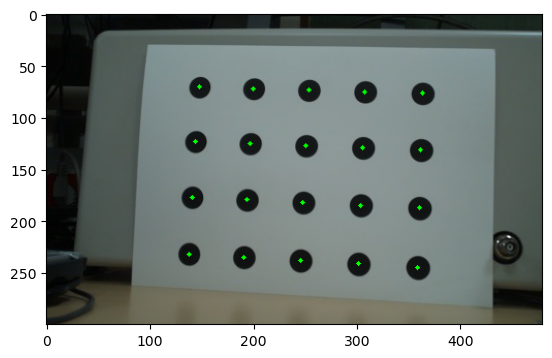

ImagenesCirculos/Imagen_circulos6.jpg True


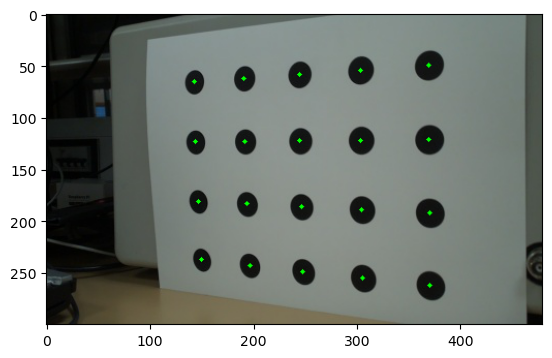

ImagenesCirculos/Imagen_circulos28.jpg True


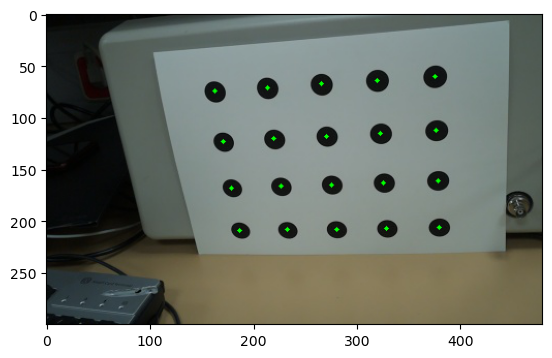

ImagenesCirculos/Imagen_circulos14.jpg True


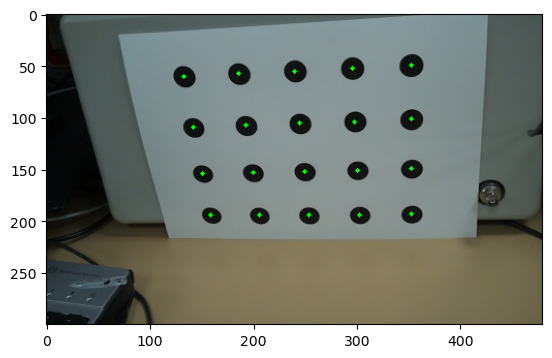

ImagenesCirculos/Imagen_circulos15.jpg True


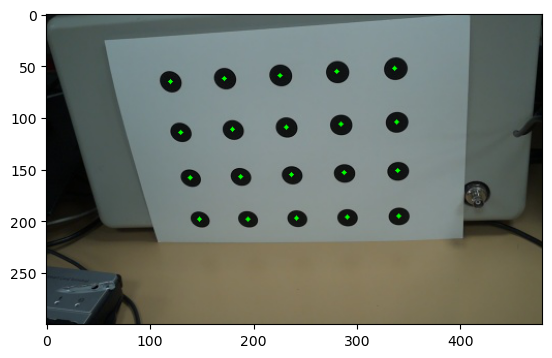

ImagenesCirculos/Imagen_circulos29.jpg True


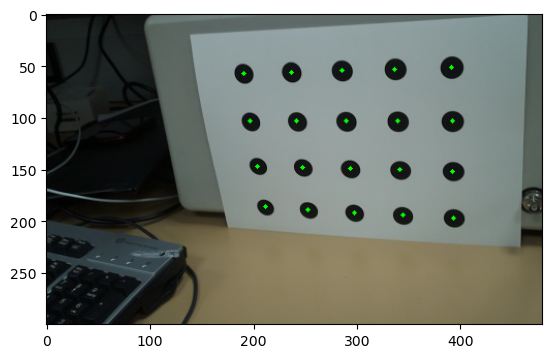

ImagenesCirculos/Imagen_circulos7.jpg True


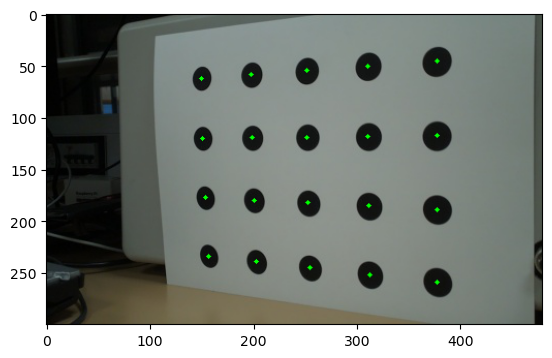

ImagenesCirculos/Imagen_circulos5.jpg True


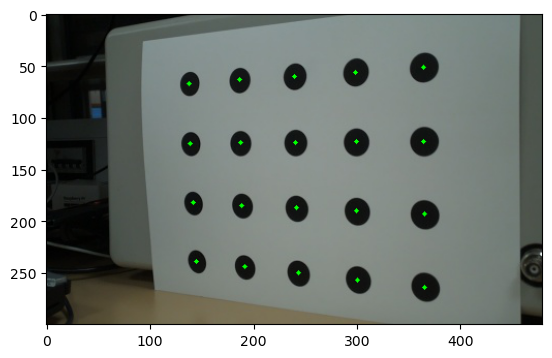

ImagenesCirculos/Imagen_circulos17.jpg True


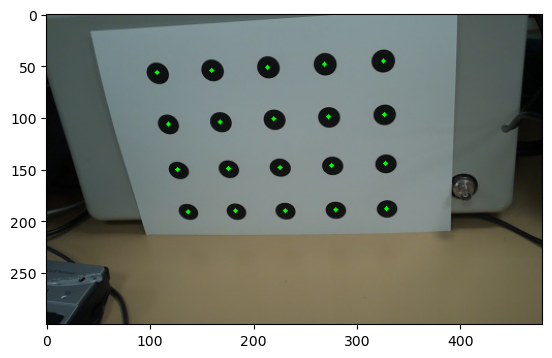

ImagenesCirculos/Imagen_circulos16.jpg True


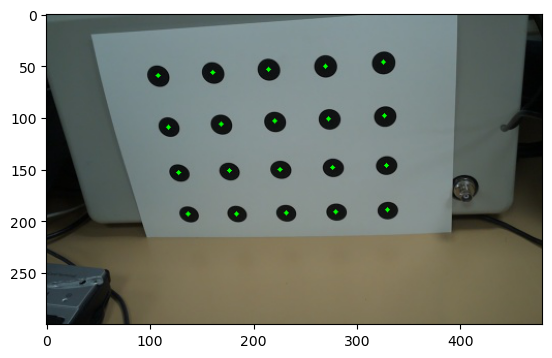

ImagenesCirculos/Imagen_circulos4.jpg False


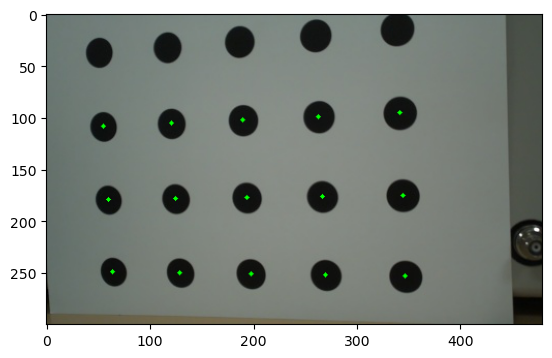

ImagenesCirculos/Imagen_circulos12.jpg True


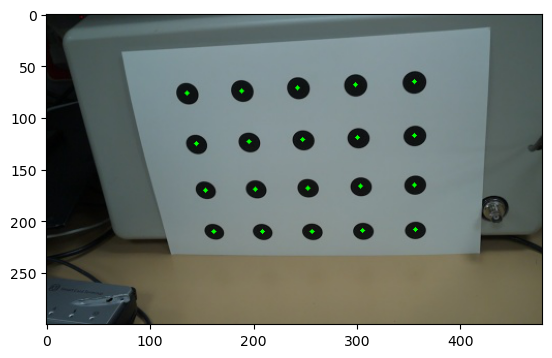

ImagenesCirculos/Imagen_circulos13.jpg True


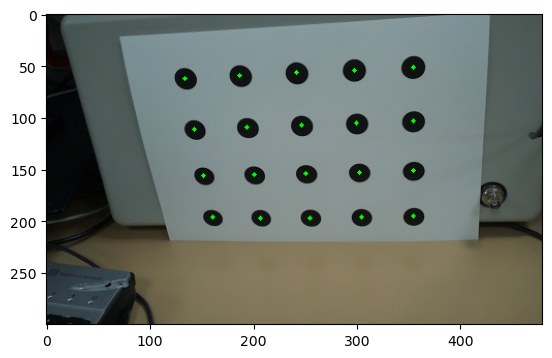

ImagenesCirculos/Imagen_circulos1.jpg True


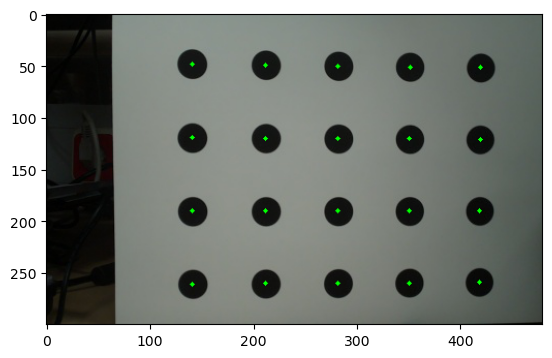

ImagenesCirculos/Imagen_circulos3.jpg True


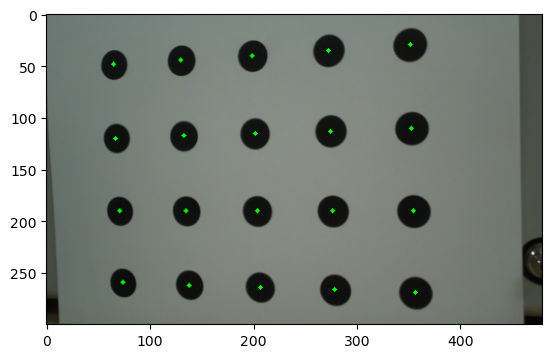

ImagenesCirculos/Imagen_circulos11.jpg True


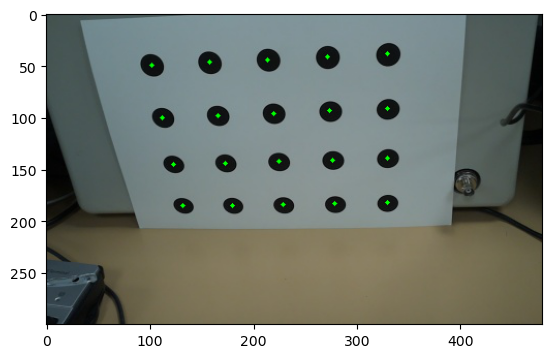

ImagenesCirculos/Imagen_circulos39.jpg False


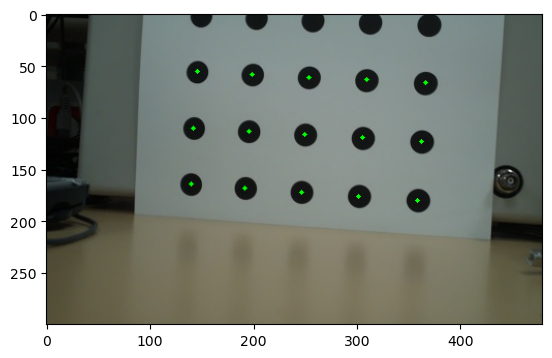

ImagenesCirculos/Imagen_circulos38.jpg True


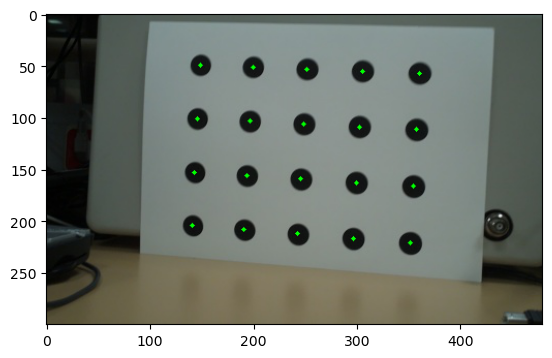

ImagenesCirculos/Imagen_circulos10.jpg True


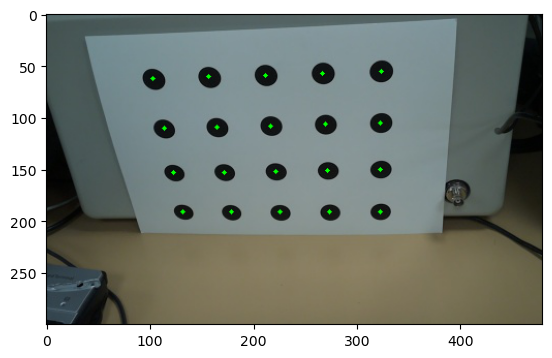

ImagenesCirculos/Imagen_circulos2.jpg True


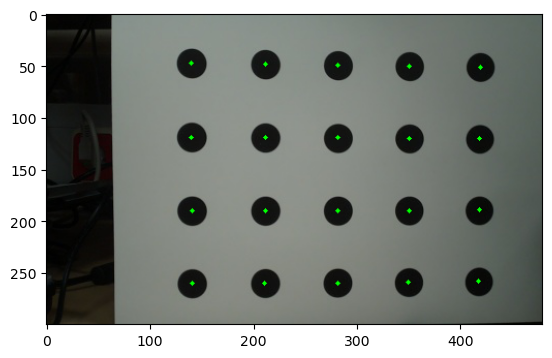

Calibración completada. Parámetros guardados en parametros_calibracion.npz


In [7]:
calibracion()

In [8]:
from picamera2 import Picamera2


ModuleNotFoundError: No module named 'picamera2'

In [ ]:
def load_calibration_params(file_path):
    try:
        calibration_data = np.load(file_path)
        camera_matrix = calibration_data['camera_matrix']
        dist_coeffs = calibration_data['dist_coeffs']
        return camera_matrix, dist_coeffs
    except Exception as e:
        print(f"Error loading calibration parameters: {e}")
        return None, None

def undistort_image(image, camera_matrix, dist_coeffs):
    h, w = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    return undistorted_image

def detect_element(frame, templates):
    max_val = -1
    max_loc = None
    detected_object = None

    for i, template in enumerate(templates):
        result = cv2.matchTemplate(frame, template, cv2.TM_CCOEFF_NORMED)
        _, current_max_val, _, current_max_loc = cv2.minMaxLoc(result)

        if current_max_val > max_val:
            max_val = current_max_val
            max_loc = current_max_loc
            detected_object = i  # Guarda el índice del objeto detectado

    threshold = 0.8  # Puedes ajustar este umbral según tus necesidades

    if max_val > threshold:
        return max_loc, detected_object
    else:
        return None, None

def stream_video(calibration_file):
    picam = Picamera2()
    picam.preview_configuration.main.size = (500, 300)
    picam.preview_configuration.main.format = "RGB888"
    picam.preview_configuration.align()
    picam.configure("preview")
    picam.start()

    # Cargar parámetros de calibración
    camera_matrix, dist_coeffs = load_calibration_params(calibration_file)

    if camera_matrix is None or dist_coeffs is None:
        return

    # Cargar las imágenes de referencia
    template_image_nutella = cv2.imread('ImagenesObjetos/Nutella.jpg', cv2.IMREAD_COLOR)
    template_image_mermelada = cv2.imread('ImagenesObjetos/Mermelada.jpg', cv2.IMREAD_COLOR)
    template_image_cacahuete = cv2.imread('ImagenesObjetos/Cacahuete.jpg', cv2.IMREAD_COLOR)

    templates = [template_image_nutella, template_image_mermelada, template_image_cacahuete]

    height, width = template_image_nutella.shape[:2]

    n_imagen = 1
    tracking = False
    tracker = cv2.Tracker_create("MIL")  # Puedes cambiar el tipo de tracker según tus necesidades

    # Contadores para cada objeto
    count_nutella = 0
    count_mermelada = 0
    count_cacahuete = 0

    while True:
        frame = picam.capture_array()

        # Corregir distorsión
        undistorted_frame = undistort_image(frame, camera_matrix, dist_coeffs)

        cv2.imshow("picam", undistorted_frame)

        if not tracking:
            match_location, detected_object = detect_element(undistorted_frame, templates)

            if match_location is not None:
                tracking = True
                tracker.init(undistorted_frame, (match_location[0], match_location[1], width, height))

                # Incrementar el contador del objeto detectado
                if detected_object == 0:
                    count_nutella += 1
                elif detected_object == 1:
                    count_mermelada += 1
                elif detected_object == 2:
                    count_cacahuete += 1
        else:
            success, bbox = tracker.update(undistorted_frame)

            if success:
                x, y, w, h = map(int, bbox)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            else:
                tracking = False

        key = cv2.waitKey(1) & 0xFF
        if key == ord('h'):
            cv2.imwrite(f'Imagen_circulos{n_imagen}.jpg', frame)
            n_imagen += 1
        elif key == ord('q'):
            break

    # Mostrar el conteo al finalizar
    print("Conteo de objetos:")
    print(f"Nutella: {count_nutella} veces")
    print(f"Mermelada: {count_mermelada} veces")
    print(f"Cacahuete: {count_cacahuete} veces")

    cv2.destroyAllWindows()

if __name__ == "__main__":
    calibration_file_path = "calibration_params.npz"
    stream_video(calibration_file_path)